# PES of Helium Dimer

Here, we explore the Potential Energy Surface of the Helium Dimer $He_2$, for various inter Helium atomic distance, between 5 to 7 Bohr with an interval of 0.2 Bohr. Note that a Helium bond does not physcially exist within this interatomic distance interval.

We shall see that using our PennyLane PES Implementation will not give a clear PES minimum. However, we can observed the tiny minimum clearly using Qamuy PES Implementation.

In [1]:
# Native Lib
import itertools as it
import copy

# External Lib
import pennylane as qml
import numpy as np
from pennylane import numpy as plnp
import matplotlib.pyplot as plt

# qanything Lib
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

### PennyLane PES Implementation

In [13]:
# Define the array of bond lenghts
step_size = 0.2
min_length = 5.4
max_length = 6.8
bond_length_arr = np.arange(min_length,max_length+step_size, step_size)

# Create Helium Dimer
mol_name = 'he2'
mol_full_name = 'helium dimer'

# Get the Helium Dimer
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[0])

# Get the Molecular Hamiltonian (Using Jordan-Wigner)
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge, basis='6-31g')

# Getting the Orbital and Excitation Index 
occupied_index, single_index, double_index = getind.generate_excite_index(num_qubits, num_elec)

# Get the Fermionic Disentangled Unitary Coupled Cluster Single Doubles (UCCSD) Excitation Order 
disentangle_order = getind.generate_disentanglement_order(occupied_index, single_index, double_index)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# Prepare a device and optimiser
dev = qml.device("default.qubit", wires=num_qubits)
optimiser_list = [qml.RMSPropOptimizer(), 
qml.AdamOptimizer(), 
qml.NesterovMomentumOptimizer(), 
qml.MomentumOptimizer(), 
qml.QNGOptimizer(), 
qml.AdagradOptimizer(), 
qml.GradientDescentOptimizer(), ]
optimiser_list_str = ['qml.RMSPropOptimizer()', 
'qml.AdamOptimizer()', 
'qml.NesterovMomentumOptimizer()', 
'qml.MomentumOptimizer()', 
'qml.QNGOptimizer()', 
'qml.AdagradOptimizer()', 
'qml.GradientDescentOptimizer()', ]
max_steps = 30

In [14]:
# Get Morse Curve
hf_energy = np.zeros(len(bond_length_arr))
vqe_uccsd_energy = np.zeros(len(bond_length_arr))
vqe_params = []
vqe_energy_hist = []
vqe_params_hist = []

for bond_iter in range(len(bond_length_arr)):
    print(f"Bond Length: {bond_length_arr[bond_iter]}")
    if bond_iter != 0:
        # Get Helium Dimer at a different interatomic distance
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[bond_iter])
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge, basis='6-31g')

    # Prepare Cost Function
    cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=True)

    # Set Initial Parameters
    params = plnp.zeros(len(disentangle_order), requires_grad=True)
    params_hist = [params]
    energy_hist = []
    check_switch = True
    opt_iter = 0
    optimiser = optimiser_list[0]  # Get the first optimiser
    # Perform VQE
    for step in range(max_steps):
        params, energy = optimiser.step_and_cost(cost_fn, params, excitations=disentangle_order)
        if step != 0:
            if check_switch and energy > energy_hist[-1]:
                opt_iter += 1
                params_hist.pop()  # Remove the last param that corresponds to the increased energy
                energy_hist.pop()  # Remove the increased energy
                params = params_hist[-1]
                if opt_iter >= (len(optimiser_list)-1):
                    opt_iter = len(optimiser_list)-1
                    check_switch = False
                optimiser = optimiser_list[opt_iter]
                print(f"Iter: {step}, Switching Optimiser to : {optimiser_list_str[opt_iter]}")
            
            else:
                energy_hist.append(energy)
                params_hist.append(params)
                print(f"Iter: {step}, Energy: {energy}")
        
        else:
            energy_hist.append(energy)
            params_hist.append(params)
            print(f"Iter: {step}, Energy: {energy}")
    
    # Get the minimum point
    hf_energy[bond_iter] += energy_hist[0]
    min_energy_ind = np.argmin(np.asarray(energy_hist))
    vqe_uccsd_energy[bond_iter] += energy_hist[min_energy_ind]
    vqe_params.append(params_hist[min_energy_ind])
    
    vqe_energy_hist.append(energy_hist)
    vqe_params_hist.append(params_hist)

Bond Length: 5.4
Iter: 0, Energy: -5.710309486576874
Iter: 1, Energy: -5.7321997328639664
Iter: 2, Energy: -5.7357116396780405
Iter: 3, Energy: -5.739344964907634
Iter: 4, Energy: -5.740065582164293
Iter: 5, Energy: -5.7402509227971645
Iter: 6, Energy: -5.740298145298449
Iter: 7, Switching Optimiser to : qml.AdamOptimizer()
Iter: 8, Energy: -5.740298145298449
Iter: 9, Switching Optimiser to : qml.NesterovMomentumOptimizer()
Iter: 10, Energy: -5.740298145298449
Iter: 11, Energy: -5.740299146267261
Iter: 12, Energy: -5.740300484454446
Iter: 13, Energy: -5.7403020431127745
Iter: 14, Energy: -5.740303711424724
Iter: 15, Energy: -5.740305391077552
Iter: 16, Energy: -5.740307000509323
Iter: 17, Energy: -5.7403084770633015
Iter: 18, Energy: -5.740309777372974
Iter: 19, Energy: -5.740310876346003
Iter: 20, Energy: -5.740311765126573
Iter: 21, Energy: -5.740312448399165
Iter: 22, Energy: -5.7403129413603455
Iter: 23, Energy: -5.740313266634734
Iter: 24, Energy: -5.74031345135429
Iter: 25, Energ

In [15]:
# Obtained from Psi4 Quantum Chemistry Package
hf_reference_helium_dimer = [-5.710309486576869,
 -5.710317641944328,
 -5.71032101492038,
 -5.710322066533509,
 -5.710322125066712,
 -5.710321850562081,
 -5.710321533728425,
 -5.710321277626022,]

fci_reference_helium_dimer = [-5.740313637766549,
 -5.740321859493835,
 -5.740325090329508,
 -5.7403259565095,
 -5.740325854168215,
 -5.74032546168859,
 -5.740325066704737,
 -5.740324762496641,]

### Results

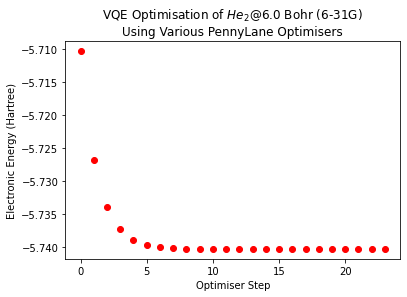

In [29]:
# Plotting the Energy Optimiser Steps
fig4, ax4 = plt.subplots()
i = 3
ax4.scatter(np.arange(len(vqe_energy_hist[i])),vqe_energy_hist[i], label='Problem-Inspired Ansatz', color='r')
ax4.set_xlabel('Optimiser Step')
ax4.set_ylabel('Electronic Energy (Hartree)')
ax4.set_title(r'VQE Optimisation of $He_2$'+'@{:.1f} Bohr (6-31G)'.format(bond_length_arr[i])+f'\nUsing Various PennyLane Optimisers')
fig4.savefig('he2_morse_vqe_opt_penny.png',format='png')

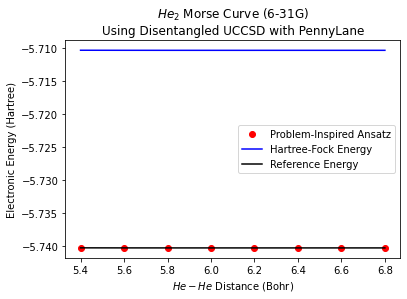

In [30]:
# Plot the results without Hartree-Fock Energy
fig, ax = plt.subplots()
ax.scatter(bond_length_arr,vqe_uccsd_energy, label='Problem-Inspired Ansatz', color='r')
ax.plot(bond_length_arr,hf_reference_helium_dimer, label='Hartree-Fock Energy',color='b')
ax.plot(bond_length_arr,fci_reference_helium_dimer,label='Reference Energy', color='k')
ax.set_xlabel(r'$He-He$ Distance (Bohr)')
ax.set_ylabel('Electronic Energy (Hartree)')
ax.set_title(r'$He_2$ Morse Curve (6-31G)'+f'\nUsing Disentangled UCCSD with PennyLane')
ax.legend()
fig.savefig('he2_morse_penny.png',format='png')

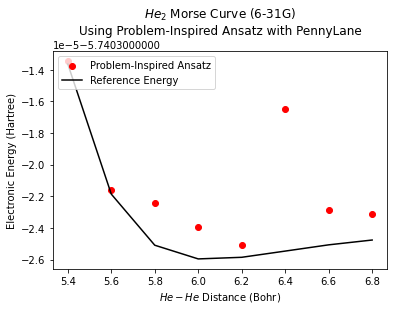

In [31]:
# Plot the same results without Hartree-Fock Energy
fig3, ax3 = plt.subplots()
ax3.scatter(bond_length_arr,vqe_uccsd_energy, label='Problem-Inspired Ansatz', color='r')
ax3.plot(bond_length_arr,fci_reference_helium_dimer,label='Reference Energy', color='k')
ax3.set_xlabel(r'$He-He$ Distance (Bohr)')
ax3.set_ylabel('Electronic Energy (Hartree)')
ax3.set_title(r'$He_2$ Morse Curve (6-31G)'+f'\nUsing Problem-Inspired Ansatz with PennyLane',y=1.05)
ax3.legend(loc='upper left')
fig3.savefig('he2_morse_penny_zoom.png',format='png')

### Discussion

Using our problem-inspired ansatz with PennyLane, the upper plot results shows that our Problem-Inspired Ansatz capable of generating the ground state of Helium dimer. However, the lower plot shows problems in optimisation convergence issues. The energy optimisation history shows that  RMSPropOptimizer was able to converge quickly for the first few steps, but had became unstable when it came close to the reference energy. As a result, the RMSPropOptimizer was replaced with slower optimisers. This to ensure that the next energy iteration will always be lower than the preceding energy. Each step of the optimisation is expensive to compute, we could only afford to do 30 optimisation steps per inter-atomic distance.

In [ ]:
# filename = 'he_morse_vqe_A.json'

# save_data = {}
# save_data['header_names'] = ['bond_length', 'fci_ref_energy', 'hf_ref_energy', 'vqe_uccsd_energy', 'vqe_params', 'vqe_energy_hist', 'vqe_params_hist', ]
# save_data['bond_length'] = bond_length_arr
# save_data['fci_ref_energy'] = fci_reference_helium_dimer
# save_data['hf_ref_energy'] = hf_reference_helium_dimer
# save_data['vqe_uccsd_energy'] = vqe_uccsd_energy
# save_data['vqe_params'] = vqe_params
# save_data['vqe_energy_hist'] = vqe_energy_hist
# save_data['vqe_params_hist'] = vqe_params_hist
# getjson.save_to_json(filename,save_data)

### Qamuy PES Implementation

In [32]:
import qamuy.chemistry as qy
from qamuy.client import Client

In [33]:
# Define the array of bond lengths
step_size_ = 0.2
min_length_ = 5.4
max_length_ = 6.8
bond_length_arr_ = 0.529177249 * np.arange(min_length_,max_length_+step_size_, step_size_) # Convert to Angstroms

# Create Helium Dimer
mol_name = 'he2'
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr_[0])
new_coords = coords.reshape((2,3)).tolist()
setting = qy.QamuyChemistryInput()
molecule = setting.target_molecule
molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
molecule.basis = "6-31g"
molecule.multiplicity = 1
molecule.num_excited_states = 0

# Set Fermion to Spin Mapping
setting.mapping.type = "JORDAN_WIGNER"

# Set Quantum Algorithm 
setting.solver.type = "VQE"

# Set cost function
setting.cost_function.type = "NONE"

# Set ansatz
setting.ansatz.type = "UCCSD"
setting.ansatz.trotter_steps = 1
setting.ansatz.reference_state = 'RHF'
setting.ansatz.initial_parameter = [0]
setting.ansatz.use_random_initial_guess = False

# My Optimiser
setting.optimizer.type = "BFGS"

# Quantum Device
setting.quantum_device.type = "EXACT_SIMULATOR"

# Ab Inito Calculation For Reference
setting.post_hf_methods.append(qy.PostHFMethod(type="FCI"))

In [34]:
# Prepare Inputs for Jobs Submission
jobs = []
for distance in bond_length_arr_:
    new_input = copy.deepcopy(setting)
    mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, distance)
    new_coords = coords.reshape((2,3)).tolist()
    new_input.target_molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
    jobs.append(client.submit(new_input))

In [35]:
# Submit Jobs for computation
results = client.wait_and_get_job_results(jobs)
outputs = [res.output for res in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.7min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  3.1min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  3.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.5min finished


### Results

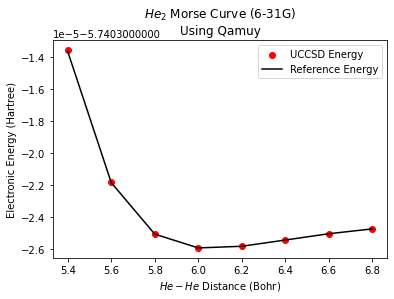

In [36]:
# Collate the Results
hf_energy_qamuy = np.zeros(len(bond_length_arr_))
ref_energy_qamuy = np.zeros(len(bond_length_arr_))
uccsd_energy_qamuy = np.zeros(len(bond_length_arr_))
for i in range(len(bond_length_arr_)):
    hf_energy = outputs[i].molecule_result.hf_result.evaluated_properties[0].energy.values[0].value
    ref_energy = outputs[i].molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value
    uccsd_energy = outputs[i].molecule_result.quantum_device_result.evaluated_properties[0].energy.values[0].value
    hf_energy_qamuy[i] = hf_energy
    ref_energy_qamuy[i] = ref_energy
    uccsd_energy_qamuy[i] = uccsd_energy

# Plot the Results
fig2, ax2 = plt.subplots()
ax2.scatter(bond_length_arr_/0.529177249,uccsd_energy_qamuy, label='UCCSD Energy', color='r')
# ax2.plot(bond_length_arr_/0.529177249,hf_energy_qamuy, label='Hartree-Fock Energy', color='b')
ax2.plot(bond_length_arr_/0.529177249,ref_energy_qamuy, label='Reference Energy', color='k')
ax2.set_xlabel(r'$He-He$ Distance (Bohr)')
ax2.set_ylabel("Electronic Energy (Hartree)")
ax2.set_title(r'$He_2$ Morse Curve (6-31G)'+f'\nUsing Qamuy')
ax2.legend()
fig2.savefig('he2_morse_qamuy.png',format='png')

In [37]:
min(uccsd_energy_qamuy)

-5.740325937561905

### Discussion

Using Qamuy, its UCCSD ansatz have remarkable argreement with the reference energy. The Helium Dimer Morse Curve shows a tiny minimum around 6 Bohr at -5.740325937561905 Hartree which is extremely close to the reference energy of -5.740325956542835 Hartree up to the $7^{th}$ decimal place. This minimum has an energy depth of about 1e-6 Hartree below dissociation energy. In comparision, the typical hydrogen molecule morse curve has an energy depth of about 0.1 Hartree, which means that a hypothetical Helium bond would be about 5 orders weaker than a Hydrogen bond. Thus, it is very unlikely that Helium bond would exist at this interatomic distance.

In [ ]:
# save_data = {}
# save_data['header_names'] = ['bond_length', 'fci_ref_energy', 'hf_ref_energy', 'vqe_uccsd_energy',]
# save_data['bond_length'] = bond_length_arr
# save_data['fci_ref_energy'] = ref_energy_qamuy
# save_data['hf_ref_energy'] = hf_energy_qamuy
# save_data['vqe_uccsd_energy'] = uccsd_energy_qamuy
# getjson.save_to_json('he2_morse_vqe_qamuy_A.json',save_data)